In [1]:
import tensorflow as tf
import numpy
from scipy import spatial, linalg
from matplotlib import pyplot
import os
import json, pickle
import pandas
from functools import partial, reduce
import importlib

import sys
sys.path.append('../libs')

import flacdb
import prepare_data
import initialize
import data_pipeline
import loss_metrics
import conv_model
import plot_batch
import load_diagnosis
import icd_util

In [2]:
%%time
H = initialize.load_hypes()
parts = ['train', 'validation']
tensors, metadata, priors = initialize.run(H, parts)

CPU times: user 3min 37s, sys: 8.84 s, total: 3min 46s
Wall time: 3min 46s


In [3]:
%%time
dataset = {part: data_pipeline.build(H, tensors[part], part) for part in parts}

CPU times: user 2.48 s, sys: 40 ms, total: 2.52 s
Wall time: 2.82 s


In [4]:
x, y = next(iter(dataset['train']))

In [97]:
%%time
importlib.reload(conv_model)
H = initialize.load_hypes()
model = conv_model.build(H, priors)

CPU times: user 8.51 s, sys: 304 ms, total: 8.82 s
Wall time: 8.64 s


In [57]:
model.predict(x)

array([[0.12945423, 0.1095729 , 0.05360407, ..., 0.571981  , 0.3139164 ,
        0.12068221],
       [0.12930039, 0.10952687, 0.05364655, ..., 0.5718706 , 0.31396607,
        0.12060641],
       [0.12921129, 0.10938195, 0.05355709, ..., 0.57210076, 0.31403545,
        0.12066981],
       ...,
       [0.12956382, 0.10955144, 0.05358043, ..., 0.57181615, 0.31353292,
        0.12074454],
       [0.12952353, 0.10946564, 0.05370154, ..., 0.5713773 , 0.31393886,
        0.1205862 ],
       [0.12909561, 0.10893148, 0.05321566, ..., 0.5726309 , 0.31510592,
        0.12119946]], dtype=float32)

In [11]:
# priors = diagnosis.mean()
-(priors * numpy.log(priors) + (1 - priors) * numpy.log(1 - priors)).mean()

0.24165781224775393

In [92]:
x, y = next(iter(dataset['validation']))
model.evaluate(x, y)

32/32 [==============================] - 3s 89ms/sample - loss: 0.3300


0.329956591129303

In [13]:
%%time
n = 100
L = 0
for x, y in dataset['train'].take(n):
    L += model.evaluate(x, y, verbose=0)
print(L / n)

0.2415937177836895
CPU times: user 35.3 s, sys: 3.7 s, total: 39 s
Wall time: 25 s


In [69]:
model.fit(
    dataset['train'],
    validation_data = dataset['validation'],
    epochs = 1,
    steps_per_epoch = 5,
    validation_steps = 5,
    verbose = True,
)

Train for 5 steps, validate for 5 steps
5/5 [==============================] - 22s 4s/step - loss: 0.2485 - val_loss: 0.3008


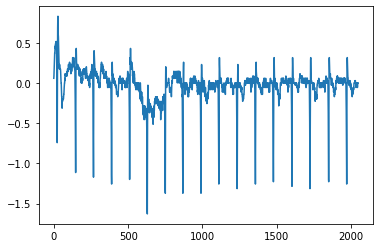

In [88]:
pyplot.plot(x['signals'][1, :, 7])

In [98]:
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
signals (InputLayer)            [(None, 2048, 15)]   0                                            
__________________________________________________________________________________________________
mask (InputLayer)               [(None, 15)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_104 (Ten [(None, 2048, 15, 1) 0           signals[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_102 (Ten [(None, 1, 15)]      0           mask[0][0]                       
___________________________________________________________________________________________